<a href="https://colab.research.google.com/github/diegosfc91/EJERCICIOS-DE-CORE-Machine-Learning/blob/main/Clasificaci%C3%B3n_utilizando_XGBoost_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carga y Exploración Inicial de Datos:


In [1]:
import pandas as pd

# Cargar el dataset
file_path = '/content/insurance.csv'  # Cambia 'ruta_del_archivo' por la ubicación de tu archivo
data = pd.read_csv(file_path)

# Exploración inicial
print("Primeras filas del dataset:")
print(data.head())

print("\nInformación del dataset:")
print(data.info())

print("\nResumen estadístico de las columnas numéricas:")
print(data.describe())

# Identificar valores faltantes
print("\nValores faltantes por columna:")
missing_values = data.isnull().sum()
print(missing_values)

# Identificar outliers con el método IQR
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
Q1 = data[numerical_columns].quantile(0.25)
Q3 = data[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

outliers = ((data[numerical_columns] < (Q1 - 1.5 * IQR)) | (data[numerical_columns] > (Q3 + 1.5 * IQR))).sum()
print("\nCantidad de outliers detectados por columna numérica:")
print(outliers)


Primeras filas del dataset:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

Resumen estadístico de las columnas 

# Preprocesamiento de Datos:

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Separar variables categóricas y numéricas
categorical_columns = data.select_dtypes(include=['object']).columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Imputación de valores faltantes
# Para variables numéricas, usar la mediana
num_imputer = SimpleImputer(strategy='median')
# Para variables categóricas, usar la moda (valor más frecuente)
cat_imputer = SimpleImputer(strategy='most_frequent')

# Codificación One-Hot para variables categóricas
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

# Escalado para variables numéricas
scaler = StandardScaler()

# Crear un transformador para las columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', num_imputer), ('scaler', scaler)]), numerical_columns),
        ('cat', Pipeline(steps=[('imputer', cat_imputer), ('encoder', one_hot_encoder)]), categorical_columns)
    ]
)

# Aplicar preprocesamiento
data_preprocessed = preprocessor.fit_transform(data)

# Convertir el resultado a un DataFrame para facilitar el manejo
# Obtener los nombres de las columnas categóricas después del One-Hot Encoding
cat_columns_encoded = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_columns)
columns_final = list(numerical_columns) + list(cat_columns_encoded)

# Crear el DataFrame final
data_preprocessed_df = pd.DataFrame(data_preprocessed, columns=columns_final)

# Mostrar las primeras filas del dataset preprocesado
print(data_preprocessed_df.head())



        age       bmi  children   charges  sex_female  sex_male  smoker_no  \
0 -1.438764 -0.453320 -0.908614  0.298584         1.0       0.0        0.0   
1 -1.509965  0.509621 -0.078767 -0.953689         0.0       1.0        1.0   
2 -0.797954  0.383307  1.580926 -0.728675         0.0       1.0        1.0   
3 -0.441948 -1.305531 -0.908614  0.719843         0.0       1.0        1.0   
4 -0.513149 -0.292556 -0.908614 -0.776802         0.0       1.0        1.0   

   smoker_yes  region_northeast  region_northwest  region_southeast  \
0         1.0               0.0               0.0               0.0   
1         0.0               0.0               0.0               1.0   
2         0.0               0.0               0.0               1.0   
3         0.0               0.0               1.0               0.0   
4         0.0               0.0               1.0               0.0   

   region_southwest  
0               1.0  
1               0.0  
2               0.0  
3               

# Implementación de Modelos de Clasificación:

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Variables predictoras y objetivo
X = data.drop('smoker', axis=1)  # Suponiendo que 'smoker' es la variable objetivo
y = data['smoker']

# Codificar la variable objetivo
y = y.map({'yes': 1, 'no': 0})

# Separar variables categóricas y numéricas
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Pipeline de preprocesamiento
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_columns),
    ('cat', cat_pipeline, categorical_columns)
])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43, stratify=y)

# Modelo de XGBoost
xgboost_model = XGBClassifier(random_state=43, eval_metric='logloss')  # Eliminado use_label_encoder

# Pipeline con XGBoost
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgboost_model)
])

# Validación cruzada
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"XGBoost Classifier:")
print(f"  Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# Entrenar y evaluar en el conjunto de prueba
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"  Test Accuracy: {test_accuracy:.4f}")



XGBoost Classifier:
  Cross-Validation Accuracy: 0.9682 ± 0.0108
  Test Accuracy: 0.9552


# Optimización de Hiperparámetros: GridSearchCV



In [7]:
from sklearn.model_selection import GridSearchCV

# Definir espacio de búsqueda para GridSearchCV (hiperparámetros de XGBClassifier)
grid_params = {
    "classifier__n_estimators": [50, 100, 200],  # Número de árboles
    "classifier__learning_rate": [0.01, 0.1, 0.2],  # Tasa de aprendizaje
    "classifier__max_depth": [3, 5, 7],  # Profundidad máxima del árbol
    "classifier__subsample": [0.8, 1.0],  # Fracción de datos usada para cada árbol
    "classifier__colsample_bytree": [0.8, 1.0]  # Fracción de características usadas
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(random_state=43, eval_metric='logloss'))  # Modelo de XGBoost
    ]),
    param_grid=grid_params,
    scoring='accuracy',
    cv=5,
    verbose=0
)

# Entrenar GridSearchCV
grid_search.fit(X_train, y_train)

# Resultados de GridSearchCV
print("\nResultados de GridSearchCV:")
print(f"Mejores Parámetros: {grid_search.best_params_}")
print(f"Mejor Score de Validación Cruzada: {grid_search.best_score_:.4f}")

# Evaluación del mejor modelo de GridSearchCV
grid_best_model = grid_search.best_estimator_
y_pred_grid = grid_best_model.predict(X_test)
accuracy_grid = accuracy_score(y_test, y_pred_grid)
print(f"Precisión en el Conjunto de Prueba: {accuracy_grid:.4f}")





Resultados de GridSearchCV:
Mejores Parámetros: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 50, 'classifier__subsample': 0.8}
Mejor Score de Validación Cruzada: 0.9720
Precisión en el Conjunto de Prueba: 0.9552


Evaluación de Modelos:


In [9]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluación del modelo inicial
initial_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=43, eval_metric='logloss'))  # Modelo inicial
])

# Entrenar y evaluar el modelo inicial
initial_model.fit(X_train, y_train)
y_pred_initial = initial_model.predict(X_test)

# Métricas del modelo inicial
initial_accuracy = accuracy_score(y_test, y_pred_initial)
print("\nModelo Inicial:")
print(f"Precisión en el Conjunto de Prueba: {initial_accuracy:.4f}")
print("Reporte de Clasificación (Modelo Inicial):")
print(classification_report(y_test, y_pred_initial))
print("Matriz de Confusión (Modelo Inicial):")
print(confusion_matrix(y_test, y_pred_initial))

# Evaluación del modelo optimizado
optimized_model = grid_search.best_estimator_

# Predecir con el modelo optimizado
y_pred_optimized = optimized_model.predict(X_test)

# Métricas del modelo optimizado
optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
print("\nModelo Optimizado:")
print(f"Precisión en el Conjunto de Prueba: {optimized_accuracy:.4f}")
print("Reporte de Clasificación (Modelo Optimizado):")
print(classification_report(y_test, y_pred_optimized))
print("Matriz de Confusión (Modelo Optimizado):")
print(confusion_matrix(y_test, y_pred_optimized))

# Comparación
print("\nComparación de Modelos:")
print(f"Precisión del Modelo Inicial: {initial_accuracy:.4f}")
print(f"Precisión del Modelo Optimizado: {optimized_accuracy:.4f}")

if optimized_accuracy > initial_accuracy:
    print("El modelo optimizado tiene un mejor rendimiento.")
elif optimized_accuracy < initial_accuracy:
    print("El modelo inicial tiene un mejor rendimiento.")
else:
    print("Ambos modelos tienen el mismo rendimiento.")




Modelo Inicial:
Precisión en el Conjunto de Prueba: 0.9552
Reporte de Clasificación (Modelo Inicial):
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       213
           1       0.85      0.95      0.90        55

    accuracy                           0.96       268
   macro avg       0.92      0.95      0.93       268
weighted avg       0.96      0.96      0.96       268

Matriz de Confusión (Modelo Inicial):
[[204   9]
 [  3  52]]

Modelo Optimizado:
Precisión en el Conjunto de Prueba: 0.9552
Reporte de Clasificación (Modelo Optimizado):
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       213
           1       0.82      1.00      0.90        55

    accuracy                           0.96       268
   macro avg       0.91      0.97      0.94       268
weighted avg       0.96      0.96      0.96       268

Matriz de Confusión (Modelo Optimizado):
[[201  12]
 [  0  55]]

Comparac

Evaluación de Modelos:



Evaluación del Modelo: Logistic Regression
  Exactitud (Accuracy): 0.9440
  Precisión (Precision): 0.8030
  Recall: 0.9636
  F1-Score: 0.8760
  ROC-AUC: 0.9735

  Matriz de Confusión:
[[200  13]
 [  2  53]]


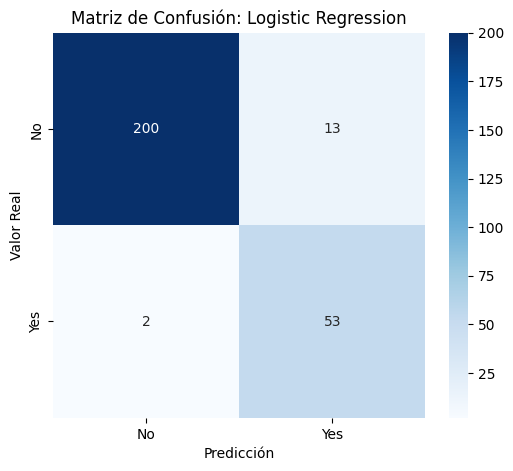

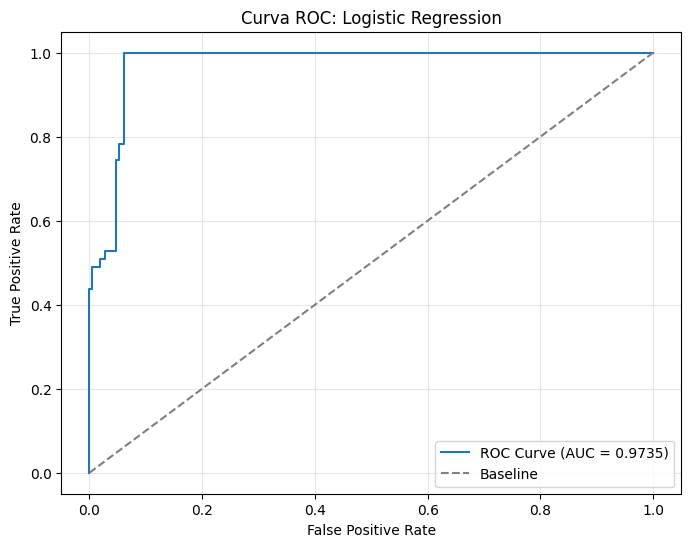


Evaluación del Modelo: K-Nearest Neighbors
  Exactitud (Accuracy): 0.9104
  Precisión (Precision): 0.7627
  Recall: 0.8182
  F1-Score: 0.7895
  ROC-AUC: 0.9418

  Matriz de Confusión:
[[199  14]
 [ 10  45]]


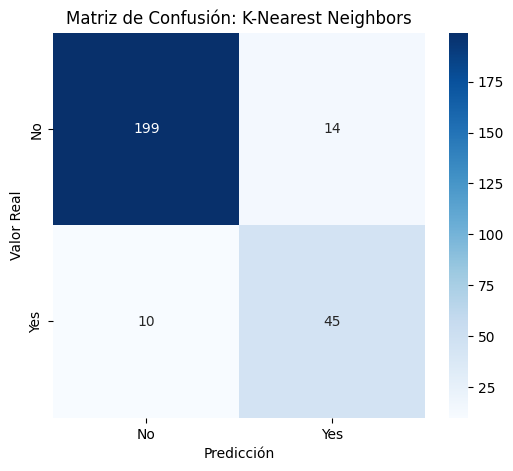

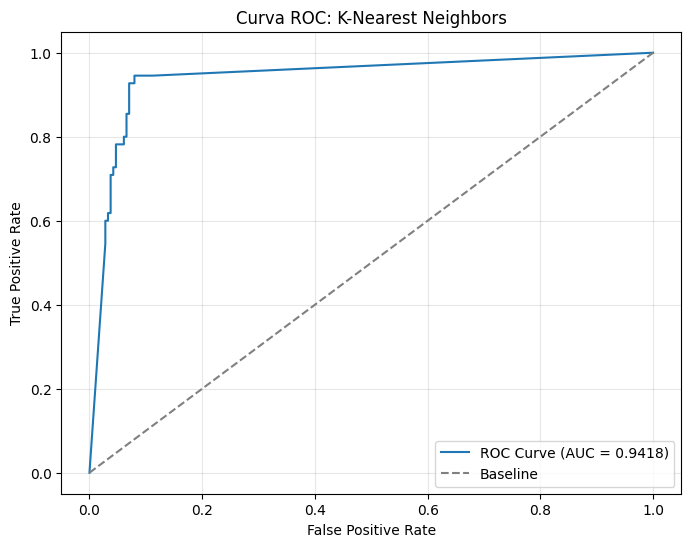


Evaluación del Modelo: Decision Tree
  Exactitud (Accuracy): 0.9366
  Precisión (Precision): 0.7969
  Recall: 0.9273
  F1-Score: 0.8571
  ROC-AUC: 0.9536

  Matriz de Confusión:
[[200  13]
 [  4  51]]


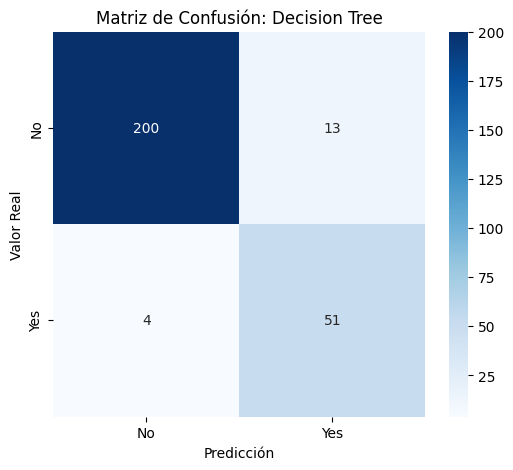

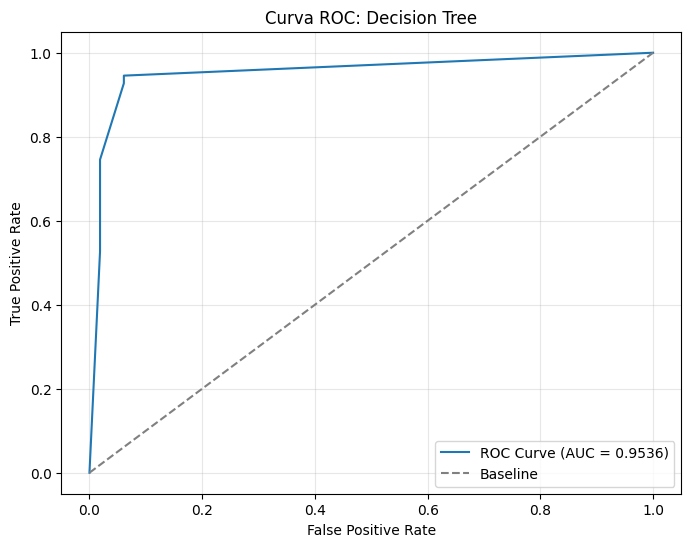

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar modelos optimizados
for model_name, result in results.items():
    print(f"\n{'='*50}\nEvaluación del Modelo: {model_name}\n{'='*50}")

    # Obtener el mejor modelo de GridSearchCV
    best_model = result["GridSearchCV"]["Best Params"]
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', models[model_name])
    ])
    pipeline.set_params(**{'classifier__' + k.split('__')[-1]: v for k, v in best_model.items()})
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, "predict_proba") else None

    # Métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"  Exactitud (Accuracy): {accuracy:.4f}")
    print(f"  Precisión (Precision): {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    if roc_auc is not None:
        print(f"  ROC-AUC: {roc_auc:.4f}")

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print("\n  Matriz de Confusión:")
    print(cm)

    # Visualización de la matriz de confusión
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.title(f'Matriz de Confusión: {model_name}')
    plt.show()

    # Curva ROC
    if roc_auc is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Baseline')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Curva ROC: {model_name}')
        plt.legend(loc='lower right')
        plt.grid(alpha=0.3)
        plt.show()


# Evaluación de Modelos:



Evaluación del Modelo: Logistic Regression
  Exactitud (Accuracy): 0.9440
  Precisión (Precision): 0.8030
  Recall: 0.9636
  F1-Score: 0.8760
  ROC-AUC: 0.9735

  Matriz de Confusión:
[[200  13]
 [  2  53]]


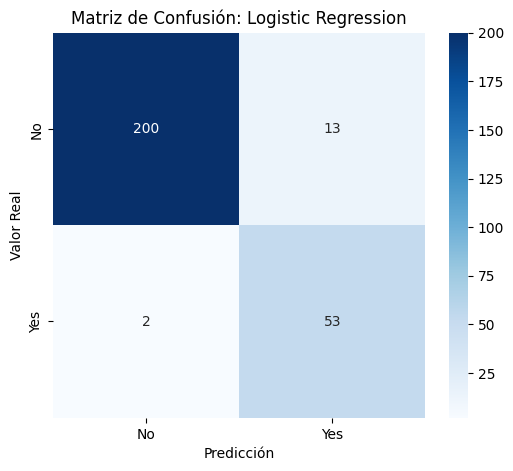

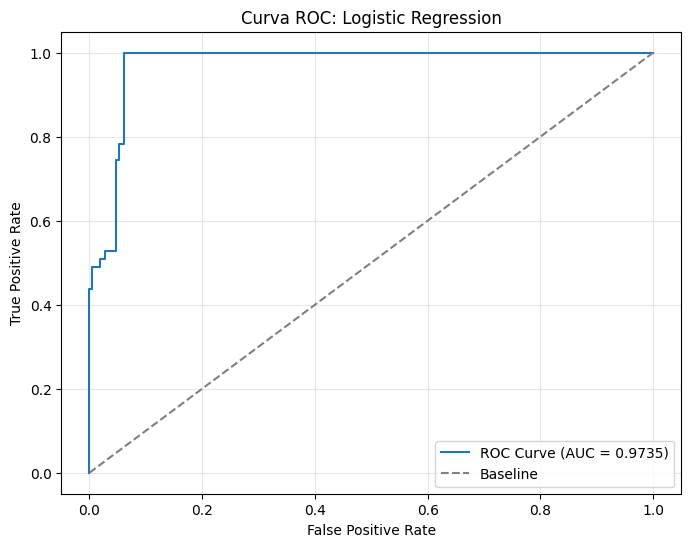


Evaluación del Modelo: K-Nearest Neighbors
  Exactitud (Accuracy): 0.9104
  Precisión (Precision): 0.7627
  Recall: 0.8182
  F1-Score: 0.7895
  ROC-AUC: 0.9418

  Matriz de Confusión:
[[199  14]
 [ 10  45]]


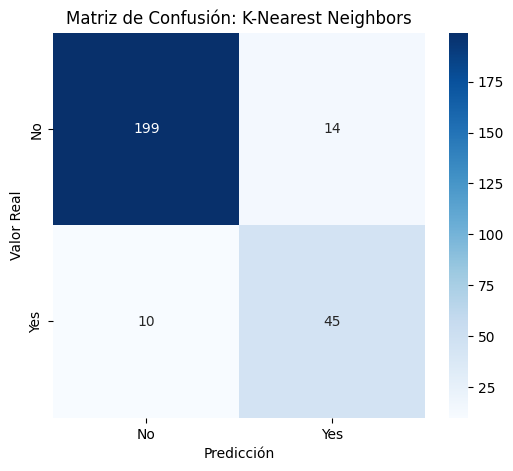

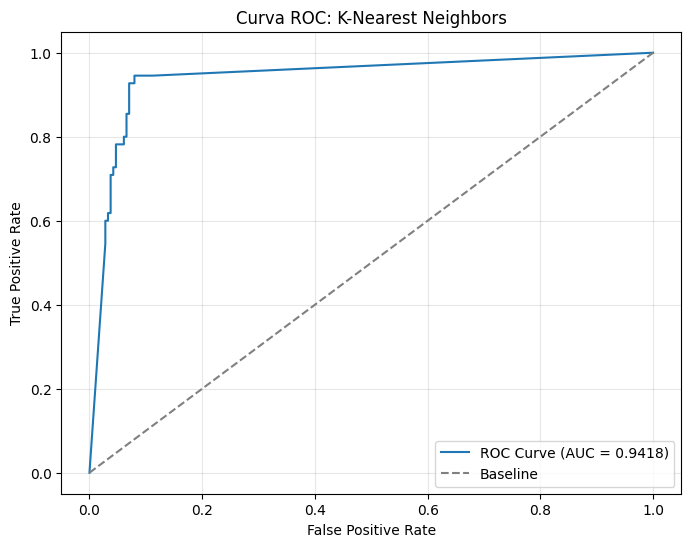


Evaluación del Modelo: Decision Tree
  Exactitud (Accuracy): 0.9366
  Precisión (Precision): 0.7969
  Recall: 0.9273
  F1-Score: 0.8571
  ROC-AUC: 0.9536

  Matriz de Confusión:
[[200  13]
 [  4  51]]


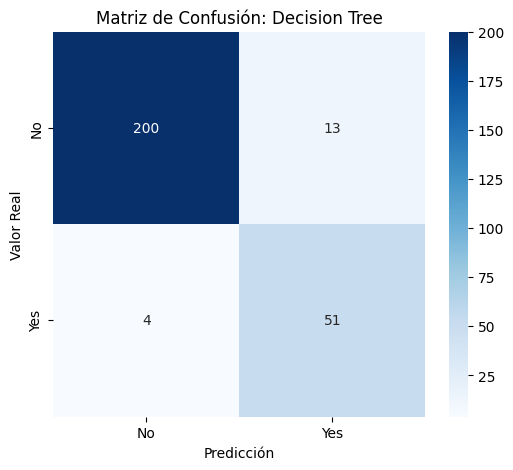

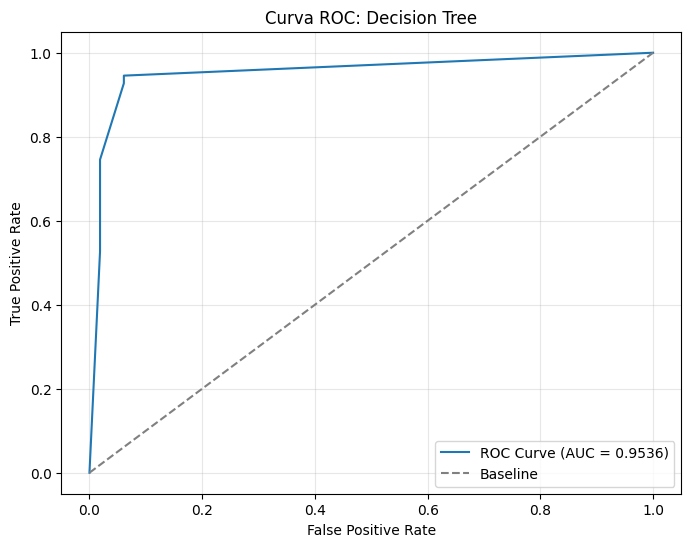

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar modelos optimizados
for model_name, result in results.items():
    print(f"\n{'='*50}\nEvaluación del Modelo: {model_name}\n{'='*50}")

    # Obtener el mejor modelo de GridSearchCV
    best_model = result["GridSearchCV"]["Best Params"]
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', models[model_name])
    ])
    pipeline.set_params(**{'classifier__' + k.split('__')[-1]: v for k, v in best_model.items()})
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, "predict_proba") else None

    # Métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"  Exactitud (Accuracy): {accuracy:.4f}")
    print(f"  Precisión (Precision): {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    if roc_auc is not None:
        print(f"  ROC-AUC: {roc_auc:.4f}")

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print("\n  Matriz de Confusión:")
    print(cm)

    # Visualización de la matriz de confusión
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.title(f'Matriz de Confusión: {model_name}')
    plt.show()

    # Curva ROC
    if roc_auc is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Baseline')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Curva ROC: {model_name}')
        plt.legend(loc='lower right')
        plt.grid(alpha=0.3)
        plt.show()
